In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

In [ ]:
# Prepare to read the label
def read_pairs(file_path, label):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    return [(line.strip().split()[0], line.strip().split()[1], label) for line in lines]

def load_all_pairs(list_dir):
    all_pairs = []
    for i in range(1, 11):
        prefix = f"{i:02d}"
        for split in ["train", "test"]:
            same_file = os.path.join(list_dir, f"{prefix}_{split}_same.txt")
            diff_file = os.path.join(list_dir, f"{prefix}_{split}_diff.txt")
            all_pairs += read_pairs(same_file, 1)
            all_pairs += read_pairs(diff_file, 0)
    return all_pairs

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch

In [ ]:
class FacePairsDataset(Dataset):
    def __init__(self, pairs, image_dir, transform=None):
        self.pairs = pairs
        self.image_dir = image_dir
        self.transform = transform or transforms.ToTensor()

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        name1, name2, label = self.pairs[idx]
        name1 += ".ppm"
        name2 += ".ppm"
        img1 = Image.open(os.path.join(self.image_dir, name1)).convert("RGB")
        img2 = Image.open(os.path.join(self.image_dir, name2)).convert("RGB")
        return self.transform(img1), self.transform(img2), torch.tensor(label, dtype=torch.float32)

In [ ]:
data_root = "/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/LFWCrop_dataset_pytorch"
face_dir = os.path.join(data_root, "faces")
list_dir = os.path.join(data_root, "lists")
print(face_dir)
print(list_dir)

pairs = load_all_pairs(list_dir)

split_idx = int(0.9 * len(pairs))
train_pairs = pairs[:split_idx]
val_pairs = pairs[split_idx:]

# Transform --> change pic size!!!!!
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Dataset and DataLoader
train_dataset = FacePairsDataset(train_pairs, face_dir, transform=transform)
val_dataset = FacePairsDataset(val_pairs, face_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/LFWCrop_dataset_pytorch/faces
/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/LFWCrop_dataset_pytorch/lists


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import numpy as np

In [ ]:
import timm

In [ ]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Using Euclidean distance
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss = (label) * torch.pow(euclidean_distance, 2) + \
               (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        return loss.mean()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Embedded ViT and Siamese
class ViTEmbeddingNet(nn.Module):
    def __init__(self, model_name='vit_base_patch16_224', pretrained=True):
        super(ViTEmbeddingNet, self).__init__()
        self.vit = timm.create_model(model_name, pretrained=pretrained)
        self.vit.reset_classifier(0)  # move classifier head

    def forward(self, x):
        return self.vit(x)

class SiameseNetwork(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNetwork, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        out1 = self.embedding_net(x1)
        out2 = self.embedding_net(x2)
        return out1, out2

In [ ]:
# Train & Eval
def train(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for x1, x2, label in loader:
        x1, x2, label = x1.to(device), x2.to(device), label.to(device)

        optimizer.zero_grad()
        out1, out2 = model(x1, x2)
        loss = criterion(out1, out2, label)
        loss.backward()
        optimizer.step()

        dist = F.pairwise_distance(out1, out2)
        pred = (dist < 0.5).float()
        correct += (pred == label).sum().item()
        total += label.size(0)
        total_loss += loss.item()

    return total_loss / len(loader), correct / total

def evaluate(model, loader, device, threshold=0.5):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x1, x2, label in loader:
            x1, x2, label = x1.to(device), x2.to(device), label.to(device)
            out1, out2 = model(x1, x2)
            dist = F.pairwise_distance(out1, out2)
            pred = (dist < threshold).float()
            correct += (pred == label).sum().item()
            total += label.size(0)
    return correct / total

def compute_val_loss(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for x1, x2, label in loader:
            x1, x2, label = x1.to(device), x2.to(device), label.to(device)
            out1, out2 = model(x1, x2)
            loss = criterion(out1, out2, label)
            total_loss += loss.item()
    return total_loss / len(loader)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

[Epoch 1/10] Train Loss: 2.65193, Train Acc: 0.51265 | Val Loss: 0.24235, Val Acc: 0.56483
[Epoch 2/10] Train Loss: 0.22966, Train Acc: 0.62517 | Val Loss: 0.22091, Val Acc: 0.66900
[Epoch 3/10] Train Loss: 0.21340, Train Acc: 0.69122 | Val Loss: 0.20304, Val Acc: 0.71517
[Epoch 4/10] Train Loss: 0.19188, Train Acc: 0.74244 | Val Loss: 0.17759, Val Acc: 0.78250
[Epoch 5/10] Train Loss: 0.16361, Train Acc: 0.80654 | Val Loss: 0.14282, Val Acc: 0.84817
[Epoch 6/10] Train Loss: 0.12583, Train Acc: 0.87474 | Val Loss: 0.10283, Val Acc: 0.91033
[Epoch 7/10] Train Loss: 0.08139, Train Acc: 0.94591 | Val Loss: 0.06160, Val Acc: 0.97117
[Epoch 8/10] Train Loss: 0.04627, Train Acc: 0.98665 | Val Loss: 0.03311, Val Acc: 0.99600
[Epoch 9/10] Train Loss: 0.02860, Train Acc: 0.99661 | Val Loss: 0.02276, Val Acc: 0.99833
[Epoch 10/10] Train Loss: 0.02056, Train Acc: 0.99896 | Val Loss: 0.01984, Val Acc: 0.99950


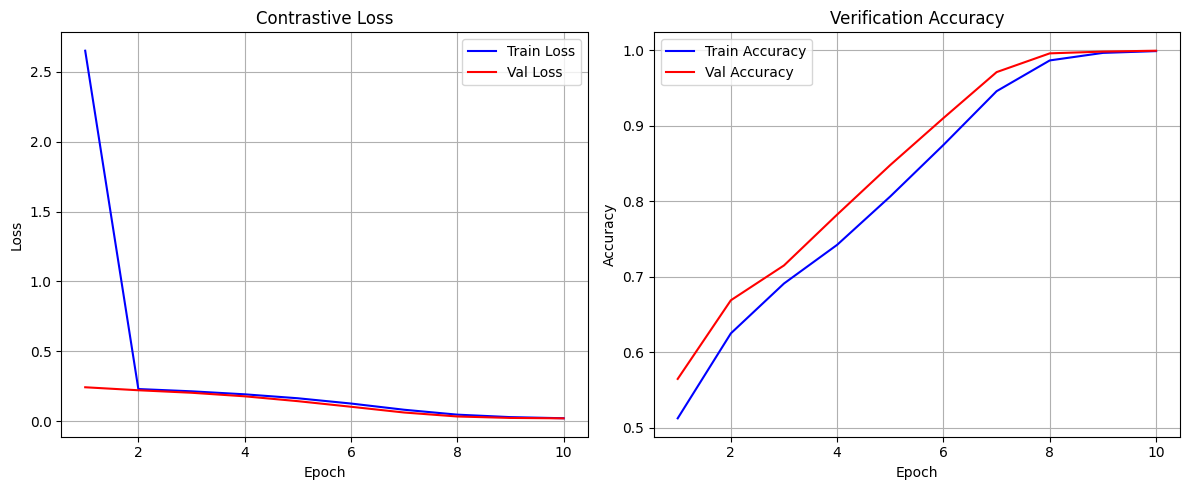

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_net = ViTEmbeddingNet()
model = SiameseNetwork(embedding_net).to(device)


criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=4e-6)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

save_dir = "/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ViT"
os.makedirs(save_dir, exist_ok=True)

for epoch in range(10):

    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    val_loss = compute_val_loss(model, val_loader, criterion, device)
    val_acc = evaluate(model, val_loader, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"[Epoch {epoch+1}/{10}] Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.5f} | Val Loss: {val_loss:.5f}, Val Acc: {val_acc:.5f}")

    epoch_data = {
        "epoch": epoch + 1,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies
    }

    import json
    with open(os.path.join(save_dir, f"epoch_{epoch+1}_data.json"), "w") as f:
        json.dump(epoch_data, f, indent=2)

# Plot the curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, epoch+2), train_losses, 'b-', label='Train Loss')
    plt.plot(range(1, epoch+2), val_losses, 'r-', label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Contrastive Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epoch+2), train_accuracies, 'b-', label='Train Accuracy')
    plt.plot(range(1, epoch+2), val_accuracies, 'r-', label='Val Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Verification Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"training_curves_epoch_{epoch+1}.png"))
    plt.close()

    if (epoch + 1) % 5 == 0 or epoch == 9:
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc
        }, os.path.join(save_dir, f"model_checkpoint_epoch_{epoch+1}.pt"))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, 'b-', label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, 'r-', label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Contrastive Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, 'b-', label='Train Accuracy')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, 'r-', label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Verification Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("Loss and Accuracy Curves.png")
plt.show()

[Epoch 1] Loss: 2.32133 | Val Acc: 0.58183

[Epoch 2] Loss: 0.22711 | Val Acc: 0.68067

[Epoch 3] Loss: 0.20734 | Val Acc: 0.73117

[Epoch 4] Loss: 0.18168 | Val Acc: 0.79900

[Epoch 5] Loss: 0.15118 | Val Acc: 0.85617

[Epoch 6] Loss: 0.11382 | Val Acc: 0.93500

[Epoch 7] Loss: 0.07154 | Val Acc: 0.98733

[Epoch 8] Loss: 0.04022 | Val Acc: 0.99717

[Epoch 9] Loss: 0.02519 | Val Acc: 0.99833

[Epoch 10] Loss: 0.01756 | Val Acc: 0.99983

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision.transforms.functional import to_pil_image

In [ ]:
print(len(val_dataset))

6000


In [ ]:
def enhance_red_in_saliency(model, dataset, device, num_samples=10, top_percent=0.1, intensity=0.9, save_dir=None):
    model.eval()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    for i in range(num_samples):
        img1, _, _ = dataset[i]
        img1 = img1.unsqueeze(0).to(device).requires_grad_()

        out1, _ = model.forward(img1, img1)
        score = out1.norm()
        score.backward()

        saliency, _ = torch.max(img1.grad.data.abs(), dim=1)
        saliency = saliency[0].detach().cpu().numpy()

        flat_saliency = saliency.flatten()
        num_top_pixels = int(len(flat_saliency) * top_percent)
        threshold = np.partition(flat_saliency, -num_top_pixels)[-num_top_pixels]

        high_saliency_mask = saliency >= threshold

        img_np = img1[0].detach().cpu().permute(1, 2, 0).numpy()
        img_np = np.clip(img_np, 0, 1)


        saliency_norm = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-5)
        alpha = saliency_norm * intensity

        modified_img = img_np.copy()

        modified_img[..., 0] = modified_img[..., 0] + alpha * (1 - modified_img[..., 0])
        modified_img[..., 1] = modified_img[..., 1] * (1 - alpha)
        modified_img[..., 2] = modified_img[..., 2] * (1 - alpha)

        fig, axes = plt.subplots(1, 2, figsize=(8, 4))

        axes[0].imshow(img_np)
        axes[0].set_title("Original")
        axes[0].axis("off")

        axes[1].imshow(modified_img)
        axes[1].set_title("Enhanced Red (Top 10% Saliency)")
        axes[1].axis("off")

        plt.tight_layout()

        if save_dir:
            save_path = os.path.join(save_dir, f"saliency_{i}.png")
            plt.savefig(save_path)
            print(f"Saved: {save_path}")

        plt.show()

In [ ]:
save_dir = "/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ViT/Saliency"
os.makedirs(save_dir, exist_ok=True)

✅ Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ViT/Saliency/saliency_0.png


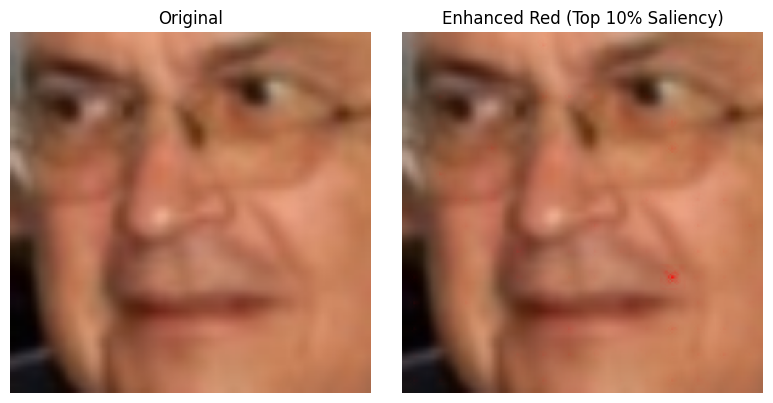

✅ Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ViT/Saliency/saliency_1.png


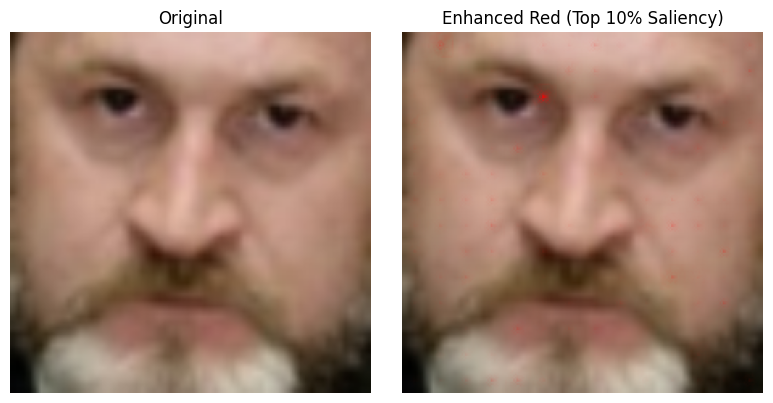

✅ Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ViT/Saliency/saliency_2.png


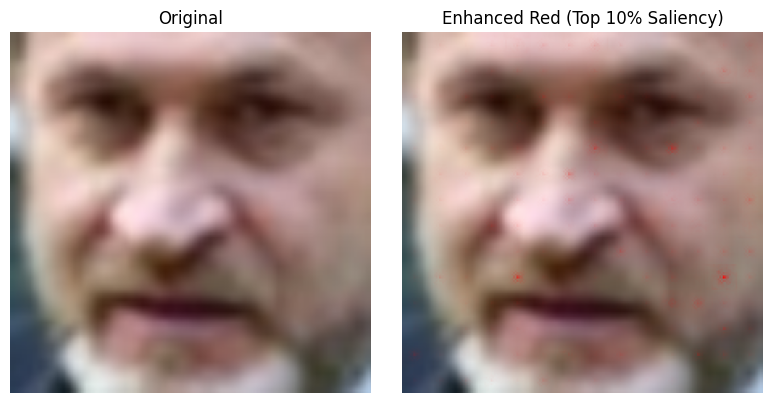

✅ Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ViT/Saliency/saliency_3.png


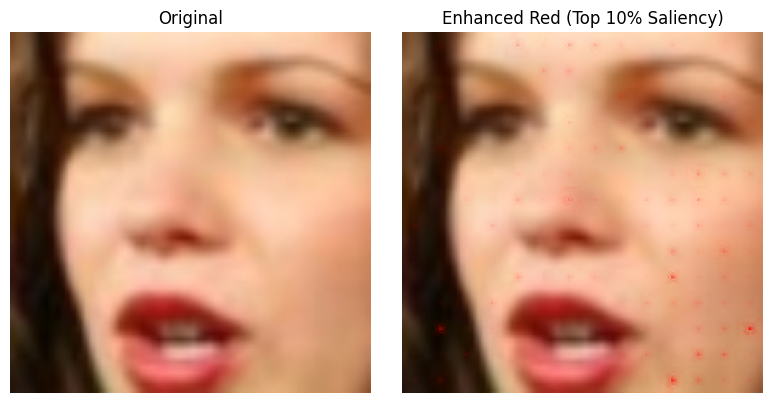

✅ Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ViT/Saliency/saliency_4.png


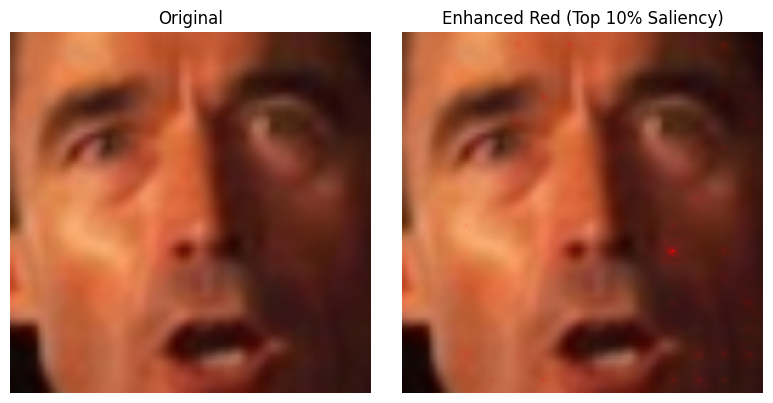

✅ Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ViT/Saliency/saliency_5.png


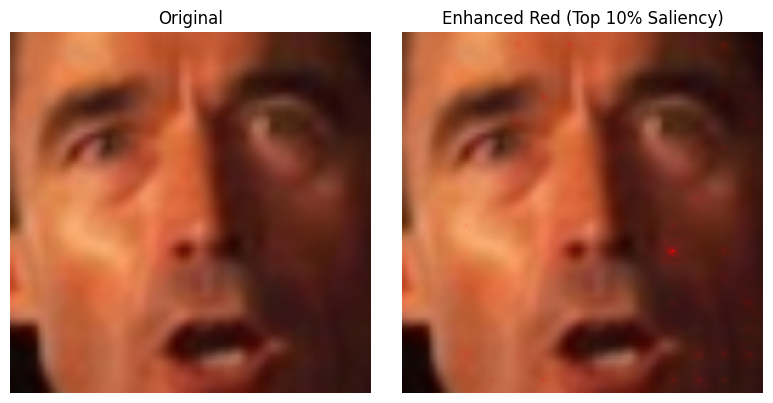

✅ Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ViT/Saliency/saliency_6.png


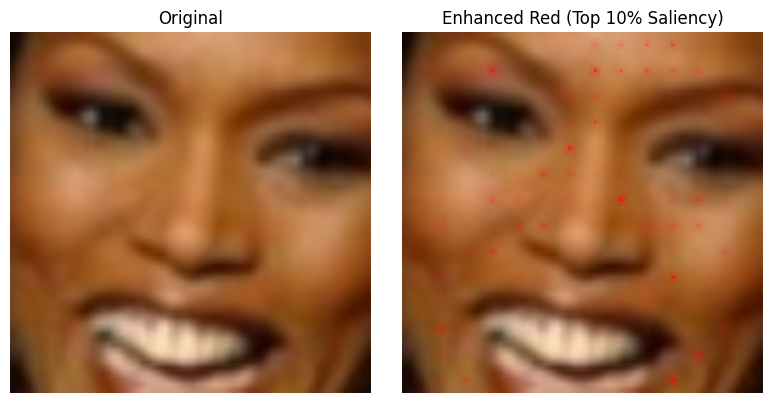

✅ Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ViT/Saliency/saliency_7.png


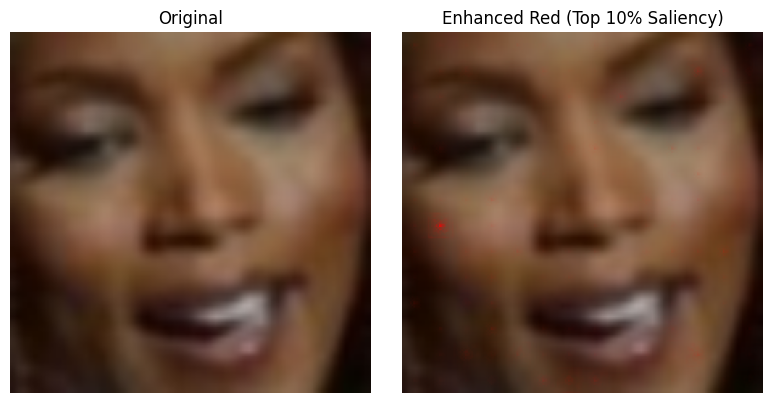

✅ Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ViT/Saliency/saliency_8.png


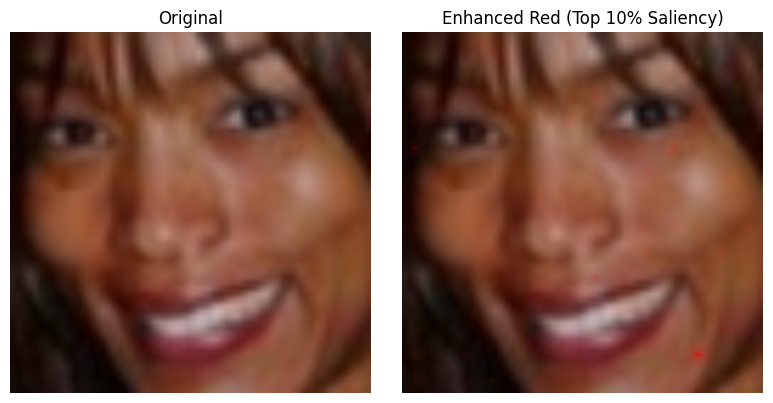

✅ Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ViT/Saliency/saliency_9.png


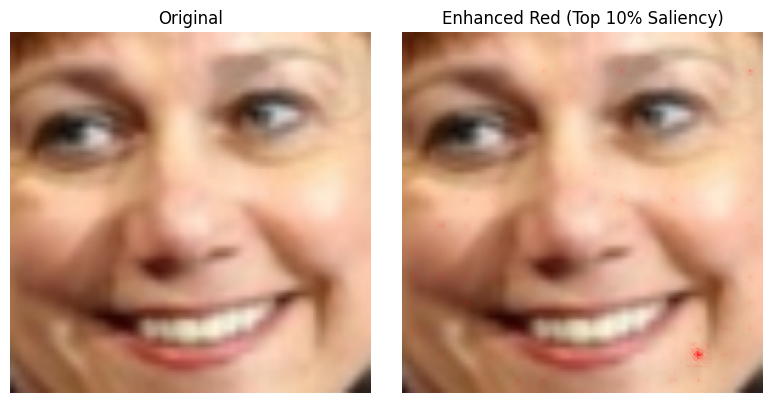

In [ ]:
enhance_red_in_saliency(model, val_dataset, device, num_samples=10, save_dir=save_dir)

In [ ]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F

In [ ]:
def predict_HED_over_time(img1_path, img2_path, model, device, transform=None, threshold=0.5, alpha=10, beta=5):
    if transform is None:
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    img1 = transform(Image.open(img1_path).convert("RGB")).unsqueeze(0).to(device)
    img2 = transform(Image.open(img2_path).convert("RGB")).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        emb1, emb2 = model(img1, img2)
        dist = F.pairwise_distance(emb1, emb2).item()
        prob = torch.sigmoid(torch.tensor(-alpha * dist + beta)).item()

    print(f"HED Model: Distance={dist:.4f}, Same probability={prob:.4f}")

    is_same = prob > 0.5

    fig, ax1 = plt.subplots(figsize=(8, 5))

    width = 0.3
    bar_positions = [0.3, 0.7]

    ax1.bar(bar_positions[0], dist, width, color='blue', label='Distance')
    ax1.set_ylabel('Distance', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    y_limit = 2
    ax1.set_ylim(0, y_limit)

    ax1.set_xticks(bar_positions)
    ax1.set_xticklabels(['Distance', 'Probability'])

    ax1.text(bar_positions[0], dist + y_limit * 0.02, f"{dist:.4f}", ha='center', va='bottom', color='blue')

    ax2 = ax1.twinx()
    ax2.bar(bar_positions[1], prob*100, width, color='orange', label='Probability')
    ax2.set_ylabel('Similarity (%)', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    ax2.set_ylim(0, 110)

    ax2.text(bar_positions[1], prob*100 + 3, f"{prob*100:.4f}%", ha='center', va='bottom', color='orange')

    plt.title('ViT Model Prediction of Part and Whole Illusion')
    plt.tight_layout()

    if os.path.exists("/content/drive"):
        save_dir = os.path.join("/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ViT", "predictions")
    else:
        save_dir = os.path.join(os.getcwd(), "output_images", "HED", "predictions")

    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"ViT_prediction_Partandwhole2.png")
    plt.savefig(save_path, dpi=300)
    print(f"Saved prediction → {save_path}")

    plt.show()

    return is_same, dist, prob

HED Model: Distance=0.2936, Same probability=0.8874
Saved prediction → /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ViT/predictions/ViT_prediction_Partandwhole2.png


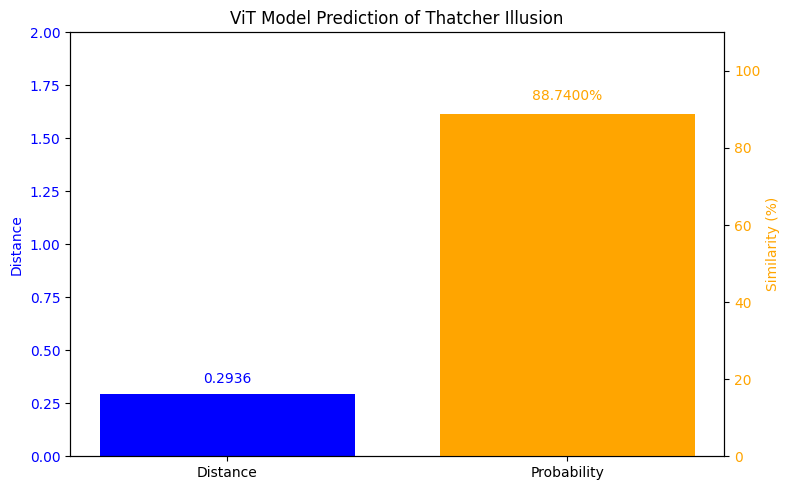

(True, 0.29355424642562866, 0.8874003291130066)

In [ ]:
# predict_HED_over_time("/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/Margaret Thatcher_test.jpg", "/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/Margaret Thatcher_test_n.jpg", model, device, threshold=0.5)
# predict_HED_over_time("/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/Margaret Thatcher_test2.jpg", "/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/Margaret Thatcher_test_n2.jpg", model, device, threshold=0.5)
# predict_HED_over_time("/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/Part_Whole_Illusion.jpg", "/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/Part_Whole_Illusion_n.jpg", model, device, threshold=0.5)
predict_HED_over_time("/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/Part_Whole_Illusion2.jpg", "/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/Part_Whole_Illusion_n2.jpg", model, device, threshold=0.5)

In [ ]:
# This part is to show the model's size and #of parameters
def count_parameters(model):

    total_params = sum(p.numel() for p in model.parameters())

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f'总参数数量: {total_params:,}')
    print(f'可训练参数数量: {trainable_params:,}')
    print(f'固定参数数量: {total_params - trainable_params:,}')
    print(f'参数内存占用 (MB): {total_params * 4 / (1024 * 1024):.2f}')

    return total_params, trainable_params

total, trainable = count_parameters(model)

with open(f'{save_dir}/model_parameters.txt', 'w') as f:
    f.write(f'总参数数量: {total:,}\n')
    f.write(f'可训练参数数量: {trainable:,}\n')
    f.write(f'固定参数数量: {total - trainable:,}\n')
    f.write(f'参数内存占用 (MB): {total * 4 / (1024 * 1024):.2f}\n')

print('参数信息已保存到 model_parameters.txt')
print(save_dir)

总参数数量: 85,798,656
可训练参数数量: 85,798,656
固定参数数量: 0
参数内存占用 (MB): 327.30
参数信息已保存到 model_parameters.txt
/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ViT/Saliency


In [ ]:
#This part of Code is to save the trained ViT model
import os
import torch
from datetime import datetime

model_name = "ViT"
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = f"/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ViT/{model_name}_{timestamp}"
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, "model.pt")
torch.save(model, model_path)

weights_path = os.path.join(save_dir, "weights.pt")
torch.save(model.state_dict(), weights_path)

output_size = None
if hasattr(model, "embedding_net") and hasattr(model.embedding_net, "vit"):
    output_size = model.embedding_net.vit.num_features

config = {
    "model_name": model_name,
    "input_size": [3, 224, 224],
    "output_size": output_size,
    "timestamp": timestamp,
    "description": "Vision Transformer (ViT) model trained on face recognition task",
    "architecture": "Siamese ViT with pretrained weights"
}

import json
with open(os.path.join(save_dir, "config.json"), "w") as f:
    json.dump(config, f, indent=4)

if 'train_losses' in locals() and 'val_accuracies' in locals():
    history = {
        "train_losses": train_losses,
        "val_losses": val_losses if 'val_losses' in locals() else [],
        "train_accuracies": train_accuracies if 'train_accuracies' in locals() else [],
        "val_accuracies": val_accuracies
    }
    with open(os.path.join(save_dir, "training_history.json"), "w") as f:
        json.dump(history, f, indent=4)

print(f"ViT模型已保存到目录: {save_dir}")

ViT模型已保存到目录: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ViT/ViT_20250505_080614
